# Lesson 1 - What's your pet

- Annotated, shorted video: https://www.youtube.com/watch?v=BWWm4AzsdLk
- course-v3.fast.ai
- 9.20 on some common misconceptions about deep learning
Mission
- You will learn how it works, before you learn why it works
- get a 'Feeling' for how Deep Learning works via coding

Goal lesson 1 (example): build classifier for distinguishing baseball vs cricket with 36(!) images

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [2]:
## is someone changes the underlying lib code, pls change
## if someone says plt sth, plot it right here
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [3]:
## fastai 'sits' on top of pytorch
## import * is not necessarily great practice in python (according to Computer Scientist
## in matlab e.g. (scientific community) this is common.
## for experimental coding import * is fine ! When going to production you can change that again. 
## Goal of experimental coding is being able testing and iterating fast
## fastai is designed to allow doing import *
from fastai import *
## visiion , Tabular Data, Language, Collaborative Filtering
from fastai.vision import *

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [4]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

Min 18:
We get data from either academics or Kaggle. Both provide strong baselines, because you can see how others performed on that data.

Here, we typically design approaches that would go to Kaggle top 10.

We are aiming differentiating between 36 different categories. In previous courses we just checked on dogs vs cats. Cat breeds are closer than dogs vs cats. This shows the progress deep learning had in recent years.

This is called fine - grained categorisation

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [5]:
## download and untar data automatically (speed depends on download speed Amazon provided)
## 
help(untar_data)

## this is a type: Union[pathlib.Path, str]
## in the help, fastai indicates this

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True)
    Download `url` if doesn't exist to `fname` and un-tgz to folder `dest`



In [6]:
path = untar_data(URLs.PETS); path ## semicolon is end of statement marker in python path tells the path used


PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet')

In [7]:
path.ls() ## fast.ai added functions in existing python libs to make it easy

['annotations', 'images']

In [8]:
## convenient function from pathlib on python3, easier to use then strings
path_anno = path/'annotations'
path_img = path/'images'

Min. 25:

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).



In [9]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/pomeranian_27.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Maine_Coon_7.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/newfoundland_29.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/shiba_inu_135.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Maine_Coon_192.jpg')]

In [10]:
## to have the labels we need to extract them
## Fine a regex tutorial here: https://www.regexone.com/
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [11]:
## ImageDataBunch uses factory methods to create input. Contains 2 / 3 Data sets
   ## Training, Validation Data, optional Test data
    
## from_name_re: pything regex module
## pat is used to extract the label from file name
## why do we have to say, what size images we have? 
## Deep Learning shrt coming needs to execute same operation to many things in parallel. Therefore,
## we need the same shape (here, to start we use square): 224 is a common size used and usually works well
## get_transforms: 'makes' things size 24, center cropping (takes the middle), resising (), augmentation (), padding ()
## Later, this will be clarified: (not sure I understood Q&A)
  ## would GPU 256 be mroe practical as power 2
  ## models give out sth 7x7 in final later so GPU () so 7 times bunch of 2 ?
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs)
## Later
## In Deep Learning, we need to normalise data. Otherwise hard to train 
## pixel values start out from 255, channels might tend to be bright or dark. 
## It helps if red green blue channel has mean 0 and standard deviation of 1
data.normalize(imagenet_stats)

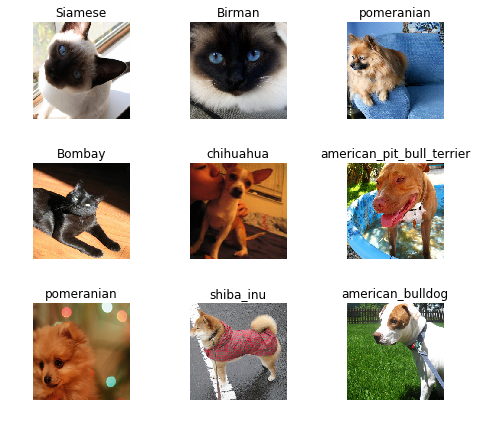

In [12]:
## Min. 33.45 
## it is common, when checking data that pictures can be 'screwed'
data.show_batch(rows=3, figsize=(7,6))

In [13]:
## ... DataBunch: .classes is the name for labels here
print(data.classes)
## all labels we found from filenames with the regex
## we have 37 possible categories
## property c in ImageDataBunch: roughly the number of classes (labels) for classification problems
## --> for regression or multi label that is different
len(data.classes),data.c

['pomeranian', 'Maine_Coon', 'newfoundland', 'shiba_inu', 'beagle', 'Bengal', 'British_Shorthair', 'Egyptian_Mau', 'miniature_pinscher', 'Birman', 'english_cocker_spaniel', 'leonberger', 'Abyssinian', 'american_bulldog', 'german_shorthaired', 'Siamese', 'staffordshire_bull_terrier', 'pug', 'american_pit_bull_terrier', 'basset_hound', 'english_setter', 'Russian_Blue', 'saint_bernard', 'chihuahua', 'yorkshire_terrier', 'Ragdoll', 'havanese', 'samoyed', 'keeshond', 'scottish_terrier', 'Persian', 'Sphynx', 'japanese_chin', 'Bombay', 'wheaten_terrier', 'boxer', 'great_pyrenees']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [14]:
## in fast.ai a learner is the general concept for 'things' that can learn.
## ConvLearner is a subclass if learner
## 2 things are needed
    ## What is your data? Takes a Databunch
    ## What is your model? here resnet 34
    ## What is your metrics? this gets printed out, here the error rate
learn = ConvLearner(data, models.resnet34, metrics=error_rate)
## Resnet work 'extremely well' most of the time
## here we take resnet34 (instead of resnet50) because it trains faster

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/jupyter/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 144010621.26it/s]


Transfer Learning: take a pre-trained model, that also knows sth and re-use for your idea
   1/100 or less time with 1/100 less data

WHAT is this this downloading? It downloads a pre-trained model. 
Trained by looking at around 1.5 million pics of around a 1000 things
   the set also contains some set
   We have the weights downloaded, hence the model knows sth about shapes and specifically cats
   see example yo distinguis cricket and baseball with 37 pics

Overfitting: 
- validation set is a set of images that the trained model does not get to look at
- the metrics are based on the validation set
- DataBunch creates (?CORRECT?) the validation set

In [17]:
## for_one_cycle: in practice usually better! more accurate and faster
## paper is around a year old
## https://sgugger.github.io/the-1cycle-policy.html
## thsi course will explain this
## use tabe here: learn.f
## use shift - tab to get inout parameters: learn.fit_one_cycle()
learn.fit_one_cycle(4)

## What is the 4 'epoch': how many times do we show the dataset to the model? 4 times here. 
## if we show that too often, the model overfits
## 4 is a good start

## this creates a set of weights . coefficient

## Note: learn.fit_one_cycle(4) actually just fine tunes the last layers. the ones before are frozen, see section below

Total time: 02:14
epoch  train loss  valid loss  error_rate
1      0.240460    0.217021    0.057884    (00:33)
2      0.290828    0.207481    0.064538    (00:33)
3      0.216054    0.194009    0.062542    (00:33)
4      0.164075    0.187400    0.056554    (00:34)



In [18]:
## we just save the weights, so we safe the time used above 56secs
## goes to a model subdirectory, the same place the data came from
## saving different models, from dfferent databunches, from different datasets should cause no issue: all kept separate
learn.save('stage-1')

Minute 47:30: on how to use the course : RUN CODE.
Ask question: what goes in, what gpes out? This section is answering the question what goes out, while before we looked at 'what goes in'

Minute 49.40: remarks (like fast.ai, on top of google tensorflow)

Minite 51.10: 
- on NLP 'breakthrough: https://www.wired.com/story/ai-can-recognize-images-but-understand-headline/
- Semantic guthub search: https://towardsdatascience.com/semantic-code-search-3cd6d244a39c / https://github.com/hamelsmu/code_search

Continues with presenting ex- succesful fast.ai students

beating google: https://www.technologyreview.com/s/611858/small-team-of-ai-coders-beats-googles-code/

Question: why resnet & not inception?
- there are many different architectures, resnet (and fast.ai) often win benchmark contests though
- fast.ai on benchmarks: https://dawn.cs.stanford.edu/benchmark/#imagenet
- inception is fine, uses lots of memory though

Lesson resumes 1.05:55


## Results

Lets compare these results to the results in the paper, 2012: http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf

- section experiments, on accuracy
- they use 'cat' specific models! Fast.ai and deepl learning aims using general models
- Result (Oxford researchers): accuracy of 59%
- here, fast.ai 2018 with fit one cycle wth 3 lines of code (essentially) 94% accuracy, that is 6% error

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [21]:
## the learn object knows 2 things: 1. whats your data 2. what is your model (trained in this case)

interp = ClassificationInterpretation.from_learner(learn)

In [22]:
help(ClassificationInterpretation)

Help on class ClassificationInterpretation in module fastai.vision.learner:

class ClassificationInterpretation(builtins.object)
 |  Interpretation methods for classification models.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data:fastai.basic_data.DataBunch, y_pred:torch.Tensor, y_true:torch.Tensor, loss_class:type=<class 'torch.nn.modules.loss.CrossEntropyLoss'>, sigmoid:bool=True)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  confusion_matrix(self)
 |      Confusion matrix as an `np.ndarray`.
 |  
 |  most_confused(self, min_val:int=1) -> Collection[Tuple[str, str, int]]
 |      Sorted descending list of largest non-diagonal entries of confusion matrix
 |  
 |  plot_confusion_matrix(self, normalize:bool=False, title:str='Confusion matrix', cmap:Any='Blues', **kwargs) -> None
 |      Plot the confusion matrix, passing `kawrgs` to `plt.figure`.
 |  
 |  plot_top_losses(self, k, largest=True, figsize=(12, 12))
 |      Show images in `top_lo

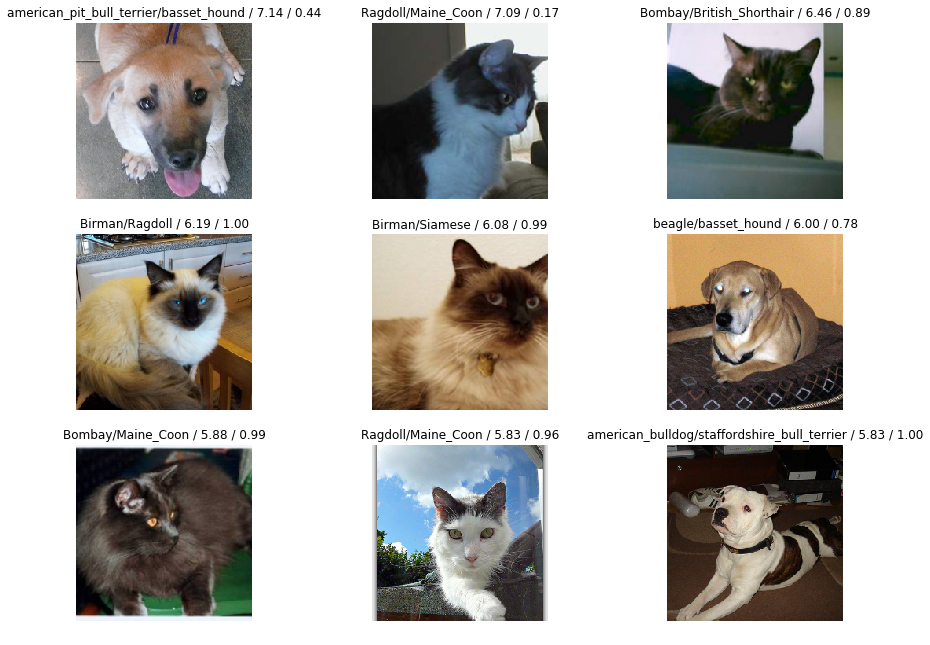

In [32]:
## this ClassificationInterpretation can give us e.g. the top losses
interp.plot_top_losses(9, figsize=(15,11))
## loss: tells you how good your prediction was. 
## If you predict that was some kind of cat with high confidence, but it was wrong, its a top loss
## shows: prediction, actual, loss, probability of actual class.
## min 1:11:15
## 1st example: it says 
  ## this is american_pit..terrier but it is actually a basset_hound
  ## probability for wrong prediction is: 7.14 
  ## probability for correct prediction (not given) was: 0.44 

In [33]:
## lets a windows pop up and gives a link into the doc
##, e.g. here: https://docs.fast.ai/vision.learner.html#ClassificationInterpretation.plot_top_losses
doc(interp.plot_top_losses)

## You can drill down into the fast.ai source code: Minute 1:12:10

  ## fast. ai tries writing small code blocks
  ## find style guide here: https://github.com/fastai/fastai/blob/master/docs/style.md


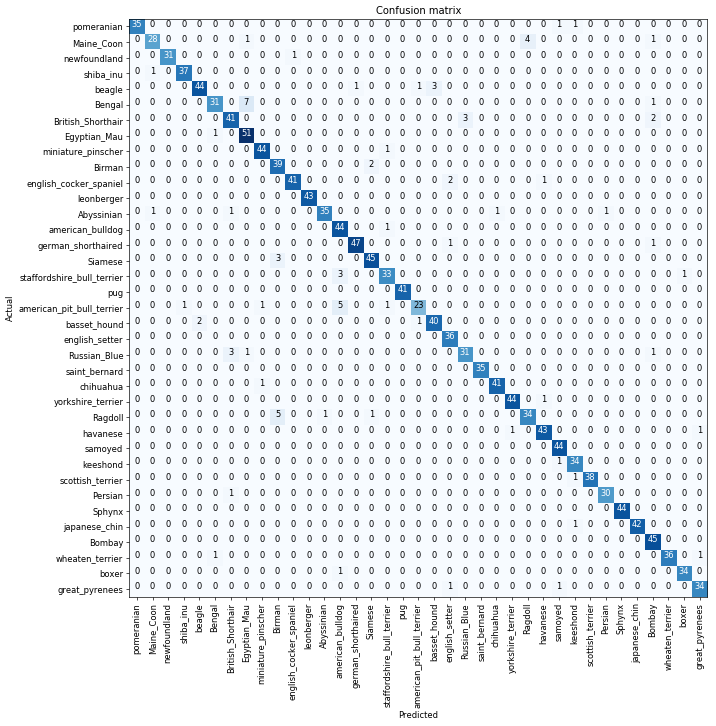

In [30]:
## Minute 1:13:30
## A confusion matrix shows for every type of dog / cat: how many times was it predicted to be that dog or cat
## the diagonal is 'strong' which is good

interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [34]:
## a Confusion matrix can be hard to read. 
## This function grab from confusion matrix the pairs that it got wrong the most.
## 1st entry, what it should have predicted, 2nd what it actually did. 3. how often that happened
interp.most_confused(min_val=2)

[('Bengal', 'Egyptian_Mau', 7),
 ('american_pit_bull_terrier', 'american_bulldog', 5),
 ('Ragdoll', 'Birman', 5),
 ('Maine_Coon', 'Ragdoll', 4),
 ('beagle', 'basset_hound', 3),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Siamese', 'Birman', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('Russian_Blue', 'British_Shorthair', 3)]

## Unfreezing, fine-tuning, and learning rates

So far we used 4 epochs and results were good. This worked because we added some layers at the end and left the previous ones as is !

We could instead train the entire model

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [35]:
learn.unfreeze()

In [36]:
## Note, the error gets worse!
learn.fit_one_cycle(1)

Total time: 00:42
epoch  train loss  valid loss  error_rate
1      1.110441    0.603065    0.192947    (00:42)



Why is the error getting worse?
- Intuitive understanding of ConvNets as of Minute 1:16:28
- paper to visulaize layers of conv net
- red, green blue pixel values go into a simple computation in 1st layer, result to 2nd layer and so on 
- ... up to 1000 layers, resnet has 34 e.g.
- output 1st layer: draw pic of coefficient, see minute 1:17:50
- paper,  https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf
- ImageNetpre-trained ConvNet: generally this simpel trained filter finds groups of pixels, 
  - Layer 1 (page 824) : 1 line
      e.g. going into a certain direction or changing colours
  - Layer 2  (page 825) : 2 lines, 1 line repeated
      takes results of layer 1 filters and creates several filters
      e.g. one example looks for corners, right hand curves, circles
  - 3rd layer can find combos from Layer 1 & Layer 2: repeating patterns of 2d objects
  - layer 4 can combine layer 3 things, it can detect dog faces already
  - layer 5 can find eyeballs of animals, faces of particular breeds of dogs
  ...
  - layer 34 or more: imagine !
  - the patterns correspond to parts of pictures, which 'activate' them
  - corners could correspond 
    e.g. to parts of windows on the original photos, text could activate similar patterns
    
Now we say: lets retrain all of it
- But why would lines be different ever to detect, that is the starting layers will always be the same
- We _should_ train only the last layers

Conculsion: no point training starting layers really


In [37]:
## So, rollback, previous optimisation attempt not good. We take weights from Model
learn.load('stage-1')

In [38]:
## we learn that later: what is the fastest I can train this Neural Network at without 'zipping off'
learn.lr_find()

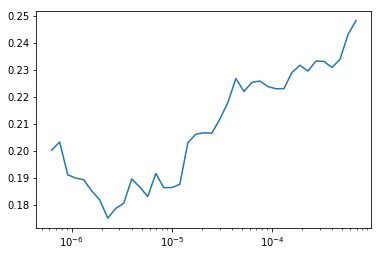

In [ ]:
## How quickly can I update the parameters in my model?

## x: what happens when I increase the learning rate
## Y: reslut / loss
learn.recorder.plot() ## plits results of lr finder

## when we go right off 10 to the negative 4, our loss gets worse !

In [39]:
learn.unfreeze()
## press shift tab after the , to find the default learning rate ==> 0.003
## 0.003 is too much to the right on x, therefore above the loss got worse
## we need a lower learning rate. Lets take 1e-6
##
## max_lr: 
## python slice: 
   ## train first layers at learning rate 1e-6, last ones at 1e-4 and distribute the other layers in between
## rule of thumb: unfreeze, take a start (pass max learning rate paramemter), end make 10 x smaller

learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 01:23
epoch  train loss  valid loss  error_rate
1      0.158657    0.177789    0.056554    (00:41)
2      0.129044    0.179033    0.053227    (00:42)



That's a pretty accurate model!

For most people, most of the time this will give a very good model (not necessarily to win kaggle competitions)

We can improve (next week) with resnet50). There you will likely get an error: GPU out of memory
Resnet is bigger, has more params and uses more of graphic card (not your normal CPU).

To avoid, reduce the batchsize bs, e.g. half it. Batchsize says How many images do you train at one time?

There is no issue other than training takes longer with reducing batchsize!

Note, video say bs=49, that was already adjusted in the notebook here.

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. Later in the course you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network might eat up our GPU memory.

In [64]:
## bs: changed from 2 to ...
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=320, bs=bs//16) 
data.normalize(imagenet_stats)

In [65]:
learn = ConvLearner(data, models.resnet50, metrics=error_rate)

In [66]:
learn.fit_one_cycle(8, max_lr=slice(1e-3))

ValueError: Expected more than 1 value per channel when training, got input size [1, 4096]

In [ ]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

In this case it doesn't, so let's go back to our previous model.

In [ ]:
learn.load('stage-1-50')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

## Other data formats

How to create labels:  Minute 1:31:30

MNIST_SAMPLE, see numbers below


In [67]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/jupyter/.fastai/data/mnist_sample')

In [68]:
path.ls() ## Train validation and so on

['valid', 'train', 'labels.csv']

In [69]:
(path/'train').ls() ## folder 3 and 7: so folder name gives the label 'ImageNet Style Dataset'

['3', '7']

In [70]:
## 
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26) ## this assumes that the folder name gives the label

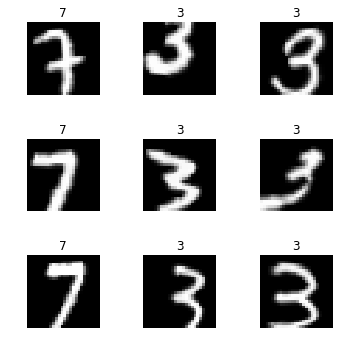

In [71]:
data.show_batch(rows=3, figsize=(5,5)) ## gives the labels by using ImageDataBunch.from_folder

In [72]:
learn = ConvLearner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/jupyter/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 142757460.23it/s]


Total time: 00:13
epoch  train loss  valid loss  accuracy
1      0.111977    0.030613    0.990186  (00:07)
2      0.061772    0.020056    0.995093  (00:06)



In [73]:
## Instead of ImageStyle Datasets, you might get a csv file
## for each file, here this says if it is a '7' or not (label = 0)

df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [74]:
## for such a csv data set use ImageDataBunch.from_csv
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

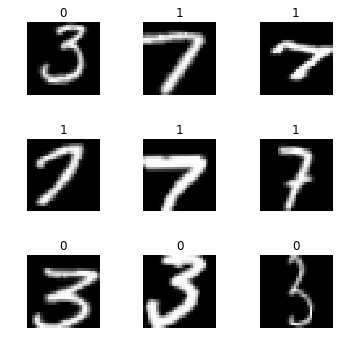

In [75]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [77]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [78]:
## path with a folder giving the lavel (similar as above, only use the regex to get the folder)
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/jupyter/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/jupyter/.fastai/data/mnist_sample/train/3/21102.png')]

In [79]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [80]:
## if non of above work, create an arbitrary function to create labels
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [81]:
#Even more flexible: write code to create an array of labels
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [82]:
## pass in array
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [84]:
## Documentation
doc(ImageDataBunch.from_name_func)

## You can copy & paste from the Documentatio, because the fast.ai Documentation is itself a python notebook
## https://github.com/fastai/fastai_docs/tree/master/docs_src
## In other words, you could clone the doc and run it as a notebook.
## This allows fast prototyoing and experimenting
## Note, github doesnt render this properly
## the fast.a docs have working examples with real datasets

Q&A : 
- library uses multiple CPU per default, but per default just one GPU. Multiple GPU in part2
- can the library work with 3d data (yes, forum thread)

# Glossary

## Mean: https://en.wikipedia.org/wiki/Mean
specifically, the sum of the values divided by the number of values. 

## Standard Deviation: https://en.wikipedia.org/wiki/Standard_deviation
In statistics, the standard deviation (SD, also represented by the lower case Greek letter sigma σ or the Latin letter s) is a measure that is used to quantify the amount of variation or dispersion of a set of data values.[1] A low standard deviation indicates that the data points tend to be close to the mean (also called the expected value) of the set, while a high standard deviation indicates that the data points are spread out over a wider range of values.

## Accuracy: https://stackoverflow.com/questions/34518656/how-to-interpret-loss-and-accuracy-for-a-machine-learning-model

The lower the loss, the better a model (unless the model has over-fitted to the training data). The loss is calculated on training and validation and its interperation is how well the model is doing for these two sets. Unlike accuracy, loss is not a percentage. It is a summation of the errors made for each example in training or validation sets.

In the case of neural networks, the loss is usually negative log-likelihood and residual sum of squares for classification and regression respectively. Then naturally, the main objective in a learning model is to reduce (minimize) the loss function's value with respect to the model's parameters by changing the weight vector values through different optimization methods, such as backpropagation in neural networks.

Loss value implies how well or poorly a certain model behaves after each iteration of optimization. Ideally, one would expect the reduction of loss after each, or several, iteration(s).

The accuracy of a model is usually determined after the model parameters are learned and fixed and no learning is taking place. Then the test samples are fed to the model and the number of mistakes (zero-one loss) the model makes are recorded, after comparison to the true targets. Then the percentage of misclassification is calculated.

For example, if the number of test samples is 1000 and model classifies 952 of those correctly, then the model's accuracy is 95.2%.
There are also some subtleties while reducing the loss value. For instance, you may run into the problem of over-fitting in which the model "memorizes" the training examples and becomes kind of ineffective for the test set. Over-fitting also occurs in cases where you do not employ a regularization, you have a very complex model (the number of free parameters W is large) or the number of data points N is very low.

## Coefficient parameter (weights?):

https://en.wikipedia.org/wiki/Coefficient